# Quickstart Guide: 

This Quickstart Guide presents a simple example of **ocean data challenge** for mapping the Sea Surface Height from sparse observations. 

The methodology is based on an Observing System Simulation Experiment (OSSE). The inputs data represent altimeter observations extracted from a realistic high-resolution ocean model simulation (NATL60). A simple mapping algorithm (Optimal Interpolation) is given as a baseline for the reconstructed SSH field from the sparse observations. Finally, a deep end-to-end learning approach is provided (Fablet et al., 2020): it already beats the OI (Beauchamp et al. 2020). Last, a comparison between the reconstructed OI, the reconstructed FP-GENN and the reference SSH fields is done to quantify the reconstruction scores.

The notebook is structured as follows:

    1) downloading the data
    2) Setup configuration of the interpolation
    3) Run the DINAE experiment
    4) Plot some figures and interpolation scores

This quickstart guide requires GPU capabilities activated to run.

In [1]:
import sys
sys.path.append("../")
from DINAE import *

Initializing DINAE libraries...
...Done


Using TensorFlow backend.


In [2]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)

In [3]:
import dask
cluster = dask.distributed.LocalCluster()
cluster.scale(1)
client = dask.distributed.Client(cluster)
client

/anaconda/envs/py35/lib/python3.5/site-packages/distributed/bokeh/core.py:56: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn('\n' + msg)


Client Scheduler: tcp://127.0.0.1:42273 Dashboard: http://127.0.0.1:41189/status,Cluster Workers: 1 Cores: 1 Memory: 9.85 GB


### 1- DOWNLOADING DATA

When downloading the 3 datasets (ref, data & oi), be sure that the names of the files will be the same than those specified in the config.yml file used to define the setup configuration. If no, please modify the config.yml file or change the downloaded file names.

##### Download Nature run SSH for mapping evaluation

In [4]:
#!wget https://s3.eu-central-1.wasabisys.com/melody/ref.nc -O "ref.nc"

##### Download Synthetic SSH observation for OI mapping

In [5]:
#!wget https://s3.eu-central-1.wasabisys.com/melody/data.nc -O "data.nc"

#####  Download OI mapping

In [6]:
#!wget https://s3.eu-central-1.wasabisys.com/melody/oi.nc -O "oi.nc"

### 2- SETUP CONFIGURATION 

In [7]:
# description of the parameters
domain   = "GULFSTREAM"
opt      = "nadirswot"
lag      = "0"             
type_obs = "mod"       # mod/obs

# main code
parser = argparse.ArgumentParser()
with open('config.yml', 'rb') as f:
    conf = yaml.load(f.read())
    
# list of global parameters (comments to add)
fileMod                 = conf['path_files']['fileMod']
fileOI                  = conf['path_files']['fileOI']
fileObs                 = conf['path_files']['fileObs']
flagTrWMissingData      = conf['data_options']['flagTrWMissingData'] 
flagloadOIData          = conf['data_options']['flagloadOIData']
include_covariates      = conf['data_options']['include_covariates']
lfile_cov               = conf['data_options']['lfile_cov']
lname_cov               = conf['data_options']['lname_cov']
lid_cov                 = conf['data_options']['lid_cov']   
N_cov                   = ifelse(include_covariates==True,len(lid_cov),0)
size_tw                 = conf['data_options']['size_tw'] 
Wsquare                 = conf['data_options']['Wsquare']
Nsquare                 = conf['data_options']['Nsquare']
DimAE                   = conf['NN_options']['DimAE']
flagAEType              = conf['NN_options']['flagAEType']
sigNoise                = conf['data_options']['sigNoise']
flagTrOuputWOMissingData= conf['data_options']['flagTrOuputWOMissingData']
stdMask                 = conf['data_options']['stdMask']
dropout                 = conf['data_options']['dropout']
start_eval_index        = conf['data_options']['start_eval_index']
end_eval_index          = conf['data_options']['end_eval_index']
start_train_index       = conf['data_options']['start_train_index']
end_train_index         = conf['data_options']['end_train_index']
wl2                     = conf['data_options']['wl2']
batch_size              = conf['training_params']['batch_size']
NbEpoc                  = conf['training_params']['NbEpoc']
Niter                   = conf['training_params']['Niter']

### 3- CREATE OUTPUT DIRECTORY

In [8]:
if flagAEType==1:
    suf1 = "ConvAE"
else:
    suf1 = "GENN"
    
if flagTrWMissingData==0:
    suf2 = "womissing"  
elif flagTrWMissingData==1:
    suf2 = "wmissing"
else:
    suf2 = "wwmissing"
    
suf3 = "FP"
suf4 = ifelse(include_covariates==True,"w"+'-'.join(lid_cov),"wocov")
dirSAVE = '.'

### 4- RUN EXPERIMENTS

#### 4.1 Read the data

In [9]:
# push all global parameters in a list
def createGlobParams(params):
    return dict(((k, eval(k)) for k in params))

list_globParams=['domain','fileMod','fileObs','fileOI',\
'include_covariates','N_cov','lfile_cov','lid_cov','lname_cov',\
'flagTrOuputWOMissingData','flagTrWMissingData',\
'flagloadOIData','size_tw','Wsquare',\
'Nsquare','DimAE','flagAEType',\
'sigNoise','stdMask','dropout','wl2',\
'start_eval_index','end_eval_index',\
'start_train_index','end_train_index',\
'batch_size','NbEpoc','Niter',\
'dirSAVE','suf1','suf2','suf3','suf4']
globParams = createGlobParams(list_globParams)   

## 1) *** Read the data ***
genFilename, x_train, y_train, mask_train, gt_train, x_train_missing, meanTr, stdTr,\
x_test, y_test, mask_test, gt_test, x_test_missing, lday_test, x_train_OI, x_test_OI = import_Data(globParams,type_obs)

1) .... Load SSH dataset (training data): data.nc
.... Load OI SSH dataset (training data): oi.nc
.... Load OI dataset (training data): oi.nc
.... # loaded samples: 238 
....... # of training patches: 238/238
2) .... Load SST dataset (test data): data.nc
.... # loaded samples: 42 
....... # of test patches: 42 /42
... mean Tr = 0.000048
... mean Tt = 0.002440
.... Training set shape 238x200x200
.... Test set shape     42x200x200
....... Generic model filename: modelNATL60_SSH_238_200_200
.... Training set shape 238x200x200x22
.... Test set shape     42x200x200x22
... (after normalization) mean Tr = -0.013482
... (after normalization) mean Tt = 0.025508


#### 4.2 Define the NN architecture

In [10]:
genFilename, encoder, decoder, model_AE, DIMCAE = define_Models(globParams,genFilename,x_train,mask_train)

(11, 11, 22, 40)
(11, 11, 22, 40)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 200, 200, 22) 0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 200, 200, 22) 0           input_1[0][0]                    
__________________________________________________________________________________________________
average_pooling2d_1 (AveragePoo (None, 50, 50, 22)   0           lambda_1[0][0]                   
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 50, 50, 40)   106480      average_pooling2d_1[0][0]        
___________________________________________________________________________

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 200, 200, 22) 0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            (None, 200, 200, 22) 0                                            
__________________________________________________________________________________________________
model_1 (Model)                 (None, 200, 200, 11) 446296      input_4[0][0]                    
                                                                 input_5[0][0]                    
__________________________________________________________________________________________________
model_2 (Model)                 multiple             0           model_1[1][0]                    
Total para

#### 4.3 Train DINAE with Fixed-Point solver    

In [11]:

FP_solver(globParams,genFilename,x_train,x_train_missing,mask_train,gt_train,meanTr,stdTr,\
          x_test,x_test_missing,mask_test,gt_test,lday_test,x_train_OI,x_test_OI,encoder,decoder,model_AE,DIMCAE)

..... Start learning AE model 2 FP/Grad FP
..... Update/initialize number of projections in DINCOnvAE model # 0
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 200, 200, 22) 0                                            
__________________________________________________________________________________________________
lambda_3 (Lambda)               (None, 200, 200, 22) 0           input_6[0][0]                    
__________________________________________________________________________________________________
input_7 (InputLayer)            (None, 200, 200, 22) 0                                            
__________________________________________________________________________________________________
model_3 (Model)                 (None, 200, 200, 11) 446296      lambda_3[0][0]                 

(11, 11, 22, 40)
Train on 214 samples, validate on 24 samples
Epoch 1/20
214/214 [==============================] - 11s 52ms/step - loss: 0.0312 - val_loss: 0.0240
Epoch 2/20
214/214 [==============================] - 7s 32ms/step - loss: 0.0291 - val_loss: 0.0233
Epoch 3/20
214/214 [==============================] - 7s 32ms/step - loss: 0.0276 - val_loss: 0.0210
Epoch 4/20
214/214 [==============================] - 7s 33ms/step - loss: 0.0262 - val_loss: 0.0229
Epoch 5/20
214/214 [==============================] - 7s 33ms/step - loss: 0.0249 - val_loss: 0.0202
Epoch 6/20
214/214 [==============================] - 7s 33ms/step - loss: 0.0215 - val_loss: 0.0157
Epoch 7/20
214/214 [==============================] - 7s 33ms/step - loss: 0.0194 - val_loss: 0.0139
Epoch 8/20
214/214 [==============================] - 7s 33ms/step - loss: 0.0209 - val_loss: 0.0186
Epoch 9/20
214/214 [==============================] - 7s 33ms/step - loss: 0.0198 - val_loss: 0.0136
Epoch 10/20
214/214 [=======

(11, 11, 22, 40)
Train on 214 samples, validate on 24 samples
Epoch 1/20
214/214 [==============================] - 20s 95ms/step - loss: 0.0115 - val_loss: 0.0085
Epoch 2/20
214/214 [==============================] - 17s 78ms/step - loss: 0.0111 - val_loss: 0.0084
Epoch 3/20
214/214 [==============================] - 16s 77ms/step - loss: 0.0110 - val_loss: 0.0084
Epoch 4/20
214/214 [==============================] - 17s 78ms/step - loss: 0.0109 - val_loss: 0.0084
Epoch 5/20
214/214 [==============================] - 17s 77ms/step - loss: 0.0109 - val_loss: 0.0083
Epoch 6/20
214/214 [==============================] - 17s 78ms/step - loss: 0.0108 - val_loss: 0.0083
Epoch 7/20
214/214 [==============================] - 17s 77ms/step - loss: 0.0108 - val_loss: 0.0083
Epoch 8/20
214/214 [==============================] - 17s 78ms/step - loss: 0.0107 - val_loss: 0.0083
Epoch 9/20
214/214 [==============================] - 17s 78ms/step - loss: 0.0107 - val_loss: 0.0083
Epoch 10/20
214/214 

### 5 - POSTPROCESSING

#### 5.1 Plot figures    

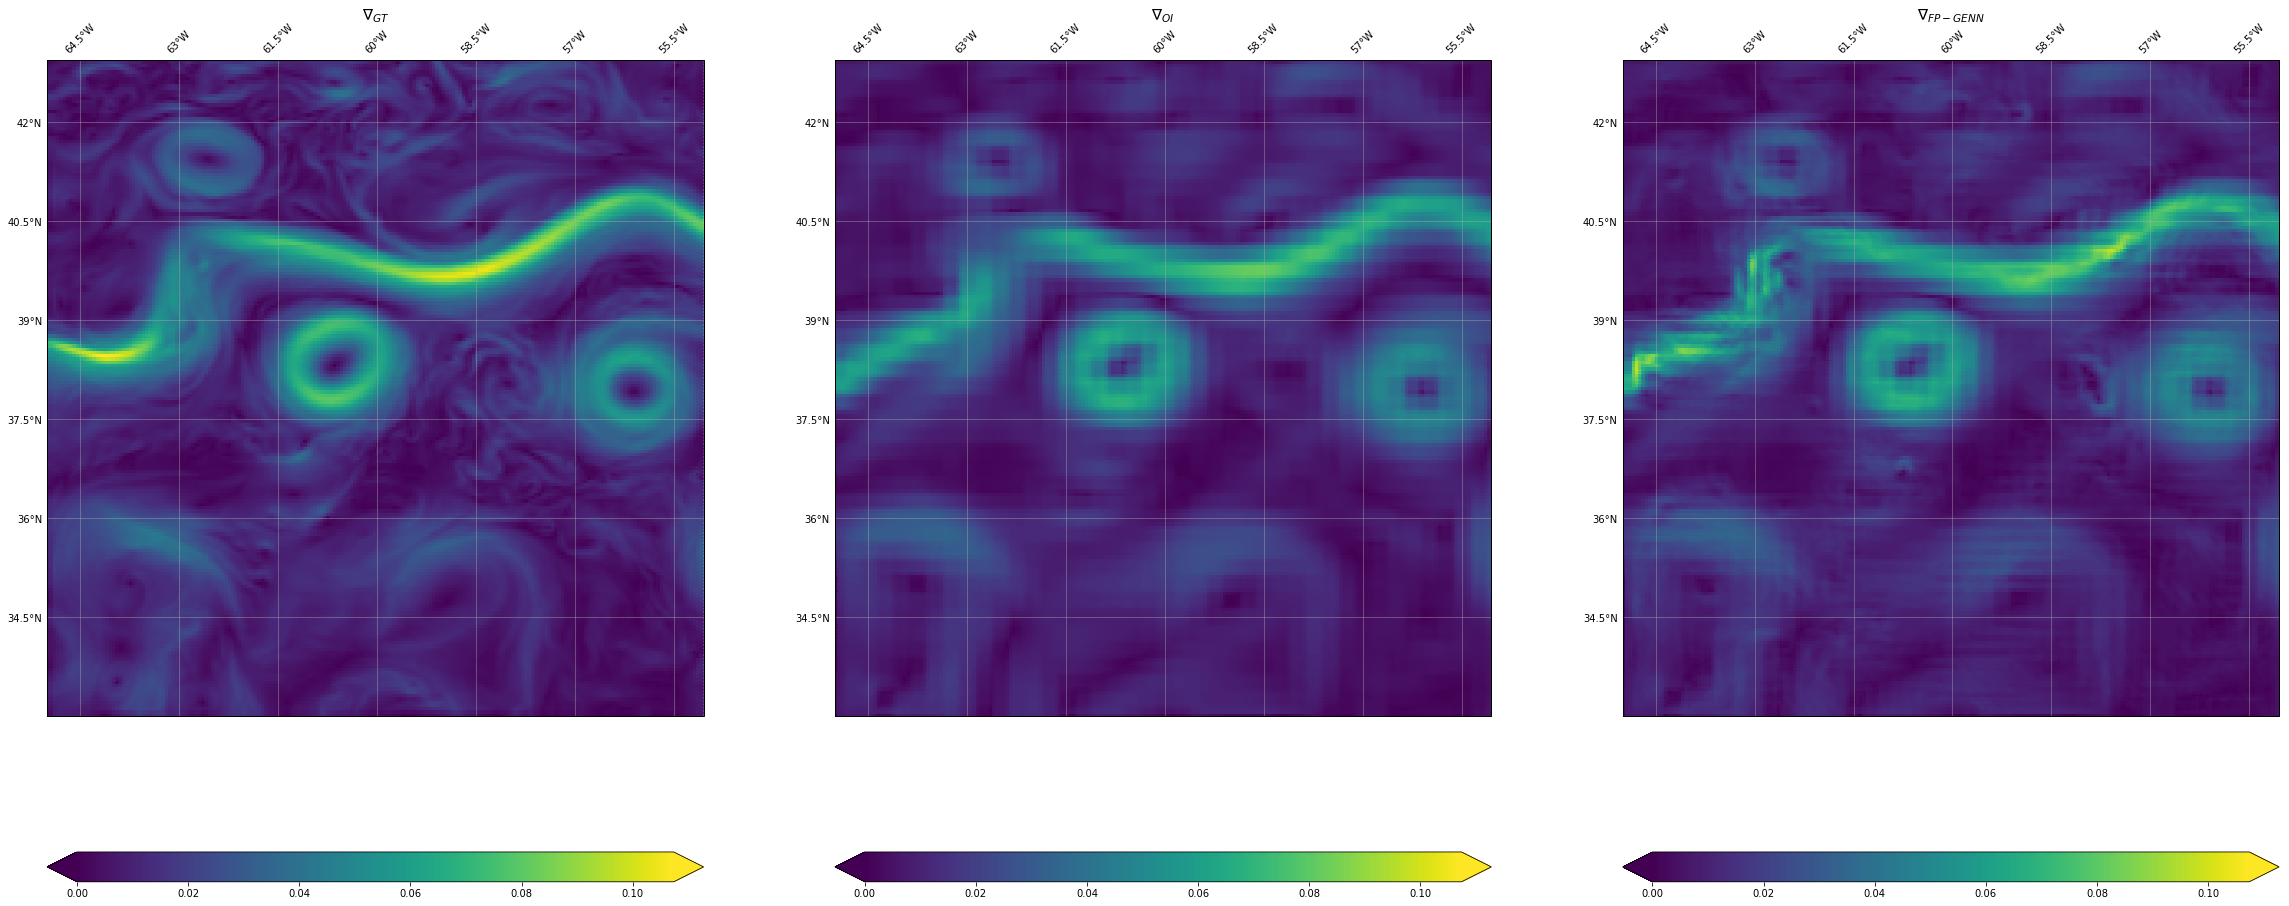

In [12]:
%matplotlib inline
from utils.plot_maps import *
from utils.fourier_spectra import *
from utils.export_NetCDF import *

# get lon, lat and extent 
lon = xr.open_dataset("ref.nc").lon.values[:200]
lat = xr.open_dataset("ref.nc").lat.values[:200]
time = xr.open_dataset("ref.nc").time.values[start_eval_index:end_eval_index]
extent = [np.min(lon),np.max(lon),np.min(lat),np.max(lat)]

# read the reference NetCDF file
GT = xr.open_dataset("ref.nc").ssh.values[start_eval_index:end_eval_index]
# read the oi NetCDF file
itrp_OI = xr.open_dataset("oi.nc").ssh_mod.values[start_eval_index:end_eval_index]
# export the itrp pickle file as NetCDF
ifile='saved_path_'+str(Niter-1).zfill(3)+'_FP_GENN_wwmissing.pickle'
ofile='FP_GENN.nc'
export_NetCDF(ifile,ofile,lon,lat,time)
# read the itrp NetCDF file
itrp_FP_GENN = xr.open_dataset("FP_GENN.nc").FP_GENN.values

i = 25 # index of the evaluation day to plot
gt           = GT[i,:200,:200]
Grad_gt      = Gradient(gt,2)
OI          = itrp_OI[i,:200,:200]
Grad_OI      = Gradient(OI,2)
FP_GENN      = itrp_FP_GENN[i,:200,:200]
Grad_FP_GENN = Gradient(FP_GENN,2)

fig, ax = plt.subplots(1,3,figsize=(40,25),squeeze=False,
                        subplot_kw=dict(projection=ccrs.PlateCarree(central_longitude=0.0)))

vmin = np.nanmin(Grad_gt) ; vmax = np.nanmax(Grad_gt)
cmap="viridis"
plot(ax,0,0,lon,lat,Grad_gt, r"$\nabla_{GT}$",\
             extent=extent,cmap=cmap,vmin=vmin,vmax=vmax)
plot(ax,0,1,lon,lat,Grad_OI, r"$\nabla_{OI}$",\
             extent=extent,cmap=cmap,vmin=vmin,vmax=vmax)
plot(ax,0,2,lon,lat,Grad_FP_GENN, r"$\nabla_{FP-GENN}$",\
             extent=extent,cmap=cmap,vmin=vmin,vmax=vmax)
plt.show()

#### 5.2 Compute RMSE and spectrum   

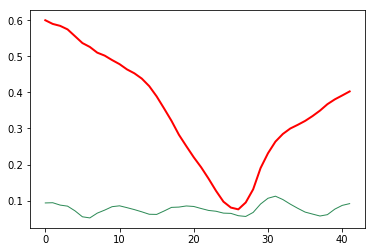

In [13]:
nrmse_OI=np.zeros(len(GT))
nrmse_FP_GENN=np.zeros(len(GT))

for i in range(0,len(GT)):
    gt           = GT[i,:200,:200]
    OI_          = itrp_OI[i,:200,:200]
    FP_GENN      = itrp_FP_GENN[i,:200,:200]
    nrmse_OI[i]      =  (np.sqrt(np.nanmean(((gt-np.nanmean(gt))-(OI-np.nanmean(OI)))**2)))/np.nanstd(gt)
    nrmse_FP_GENN[i] =  (np.sqrt(np.nanmean(((gt-np.nanmean(gt))-(FP_GENN-np.nanmean(FP_GENN)))**2)))/np.nanstd(gt)
    
# plot nRMSE time series
N=len(GT)
plt.plot(range(N),nrmse_OI,linestyle='solid',color='red',linewidth=2,label=r"$OI$")
plt.plot(range(N),nrmse_FP_GENN,linestyle='solid',color='seagreen',linewidth=1,label=r"$FP_GENN$")
plt.show()

../utils/fourier_spectra.py:101: RuntimeWarning: invalid value encountered in true_divide
  Pf_     = (Pf_/raPsd2dv1(img2,res,hanning)[1])


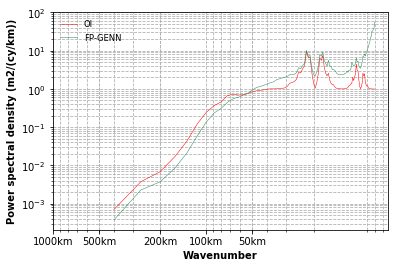

In [14]:
# Plot averaged normalize error RAPS 
f0, Pf_OI        = avg_err_raPsd2dv1(itrp_OI[:,:200,:200],GT[:,:200,:200],4,True)
f1, Pf_FP_GENN   = avg_err_raPsd2dv1(itrp_FP_GENN[:,:200,:200],GT[:,:200,:200],4,True)
wf0 = 1/f0
wf1 = 1/f1
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(wf0[1:],Pf_OI[1:],linestyle='solid',color='red',linewidth=.5,label='OI')
ax.plot(wf1[1:],Pf_FP_GENN[1:],linestyle='solid',color='seagreen',linewidth=.5,label='FP-GENN')
ax.set_xlabel("Wavenumber", fontweight='bold')
ax.set_ylabel("Power spectral density (m2/(cy/km))", fontweight='bold')
ax.set_xscale('log') ; ax.set_yscale('log')
plt.legend(loc='best',prop=dict(size='small'),frameon=False)
plt.xticks([50, 100, 200, 500, 1000], ["50km", "100km", "200km", "500km", "1000km"])
ax.invert_xaxis()
plt.grid(which='both', linestyle='--')
plt.show()